<a href="https://colab.research.google.com/github/O-Kpy/Kaggle/blob/main/tabular_playground_series_jun_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 내일 할일 normalizaition 돌리고 파이토치 필사하기, 이미지 분류 필사하기(구글 랜드마크)
# 그리고 https://www.kaggle.com/masumrumi/a-detailed-regression-guide-with-house-pricing#Fitting-model(simple-approach) 정독하기

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import skew

In [ ]:
submit = pd.read_csv('/kaggle/input/tabular-playground-series-jun-2021/sample_submission.csv')
test = pd.read_csv('/kaggle/input/tabular-playground-series-jun-2021/test.csv')
train = pd.read_csv('/kaggle/input/tabular-playground-series-jun-2021/train.csv')
train.shape, test.shape, submit.shape

((200000, 77), (100000, 76), (100000, 10))

In [ ]:
train.target.value_counts().sort_index(ascending=False).plot.bar()

In [ ]:
data=pd.concat([train, test], axis=0)

In [ ]:
data.isnull().sum().sort_values(ascending=False)
# Null값 없고

In [ ]:
data.skew().sort_values(ascending=False)
# 스케일링 해야하고

In [ ]:
# 로그변환 안하는게 성능이 더 잘 나오는데
for i in train.drop(columns=['id', 'target']).columns:
    if train[i].skew() > 0.5:
        train[i] = np.log1p(train[i]+1)
        
for i in test.drop(columns=['id']).columns:
    if test[i].skew() > 0.5:
        test[i] = np.log1p(test[i]+1)

In [ ]:
# boxcox로 Normalize하기
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

for feat in train.drop(columns=['id', 'target']).columns:
    train[feat] = boxcox1p(train[feat], boxcox_normmax(train[feat] + 1))
    
for feat in test.drop(columns=['id']).columns:
    test[feat] = boxcox1p(test[feat], boxcox_normmax(test[feat] + 1))

In [ ]:
train_agg = train.drop(columns='target').groupby('id').agg(['median'])
train_agg_col = []

for i in train_agg.columns.levels[0]:
    for j in train_agg.columns.levels[1]:
        train_agg_col.append(f'{i}-{j}')
        
train_agg.columns = train_agg_col

test_agg = test.groupby('id').agg(['median'])
test_agg_col = []

for i in test_agg.columns.levels[0]:
    for j in test_agg.columns.levels[1]:
        test_agg_col.append(f'{i}-{j}')
        
test_agg.columns = test_agg_col

In [ ]:
corr_matrix = train_agg.corr()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

to_drop = [c for c in upper.columns if any(abs(upper[c]) > 0.9)]

print(f'There are {len(train_agg.columns)} columns but {len(to_drop)} corr columns to remove')

In [ ]:
train_agg.drop(columns=to_drop)
train = train.merge(train_agg, how='left', on='id')

test_agg.drop(columns=to_drop)
test = test.merge(test_agg, how='left', on='id')

# 그냥 모델링 하기 다음에 피쳐 엔지니어링

In [ ]:
from sklearn.metrics import log_loss, make_scorer
import catboost
import lightgbm
import xgboost
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold, StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import LabelEncoder, robust_scale, MinMaxScaler

In [ ]:
x_train = train.drop(columns=['target', 'id'])
y_train = train['target']
x_test = test.drop(columns=['id'])

In [ ]:
x_train = data.loc[data['target'].notnull()].drop(columns=['id', 'target'])
y_train = data.loc[data['target'].notnull()]['target']
x_test = data.loc[data['target'].isnull()].drop(columns=['id', 'target'])

In [ ]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_train = pd.Series(y_train)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(svd_solver='auto', whiten=True)
pca.fit(x_train)

fig, ax = plt.subplots(figsize=(12,8))
xi = np.arange(1, len(x_train.columns)+1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0, 1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('number of components')
plt.xticks(np.arange(0, len(x_train.columns), step=2))

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color='red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [ ]:
pca = PCA(n_components=54,svd_solver='auto', whiten=True)
x_train = pca.fit_transform(x_train)
x_test = pca.fit_transform(x_test)

In [ ]:
x_train = robust_scale(x_train)
x_test = robust_scale(x_test)

In [ ]:
x_train_col = x_train.columns
x_test_col = x_test.columns

x_train = pd.DataFrame(robust_scale(x_train), columns=x_train_col)
x_test = pd.DataFrame(robust_scale(x_test), columns=x_test_col)

In [ ]:
# lgbm 모델
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros((len(x_test)))
for i, (train_index, valid_index) in enumerate(skf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model = lightgbm.LGBMClassifier(n_estimators=3000, learning_rate=0.05, objective='multiclass', n_jobs=-1)
  model.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_valid, Y_valid)], verbose=100, early_stopping_rounds=70, eval_metric='multi_logloss')
  preds = model.predict_proba(x_test)

In [ ]:
def objective(trial,data=x_train,target=y_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {'iterations':trial.suggest_int("iterations", 2000, 25000),
             'loss_function':'MultiClass',
              'task_type':"GPU",
              'eval_metric':'MultiClass',
              'leaf_estimation_method':'Newton',
              'bootstrap_type': 'Bernoulli',
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.5),
              'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
              'subsample': trial.suggest_uniform('subsample',0,1),
              'random_strength': trial.suggest_uniform('random_strength',10,50),
              'depth': trial.suggest_int('depth',1,15),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
              'grow_policy' : 'Lossguide'
               }
    model = catboost.CatBoostClassifier(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict_proba(X_test)


    log_loss_multi = log_loss(y_test, y_preds)
    
    return log_loss_multi

In [ ]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-06-29 06:13:26,913] A new study created in memory with name: no-name-87955b1a-a78a-4489-be76-5b41b6255ff5
[I 2021-06-29 06:14:39,022] Trial 0 finished with value: 1.7494181579682393 and parameters: {'iterations': 6086, 'learning_rate': 0.05946889834120377, 'reg_lambda': 13.839182649925533, 'subsample': 0.6415432904147128, 'random_strength': 34.354423624851144, 'depth': 5, 'min_data_in_leaf': 36, 'leaf_estimation_iterations': 8}. Best is trial 0 with value: 1.7494181579682393.
[I 2021-06-29 06:14:43,563] Trial 1 finished with value: 1.759088275861155 and parameters: {'iterations': 5430, 'learning_rate': 0.4125243175282473, 'reg_lambda': 53.77196021055085, 'subsample': 0.2378944650024809, 'random_strength': 30.013151704104995, 'depth': 7, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 4}. Best is trial 0 with value: 1.7494181579682393.
[I 2021-06-29 06:14:52,029] Trial 2 finished with value: 1.7504377105038467 and parameters: {'iterations': 20924, 'learning_rate': 0.162110

Number of finished trials: 100
Best trial: score 1.7455353430219225, params {'iterations': 9912, 'learning_rate': 0.012404639001169242, 'reg_lambda': 34.85607480479962, 'subsample': 0.010055515569231628, 'random_strength': 49.89579844259698, 'depth': 10, 'min_data_in_leaf': 49, 'leaf_estimation_iterations': 1}


In [ ]:
# catboost모델 제일 성능이 잘 나옴(NN빼고)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
preds_cat = np.zeros((x_test.shape[0], y_train.nunique()))
params_cat = {'iterations':study.best_params['iterations'],
             'loss_function':'MultiClass',
              'task_type':"GPU",
              'eval_metric':'MultiClass',
              'leaf_estimation_method':'Newton',
              'bootstrap_type': 'Bernoulli',
              'learning_rate' : study.best_params['learning_rate'],
              'reg_lambda': study.best_params['reg_lambda'],
              'subsample': study.best_params['subsample'],
              'random_strength': study.best_params['random_strength'],
              'depth': study.best_params['depth'],
              'min_data_in_leaf': study.best_params['min_data_in_leaf'],
              'leaf_estimation_iterations': study.best_params['leaf_estimation_iterations'],
              'grow_policy' : 'Lossguide'
               }

for i, (train_index, valid_index) in enumerate(skf.split(x_train, y_train)):
    X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
    Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]
    
    model = catboost.CatBoostClassifier(**params_cat)
    model.fit(X_train, Y_train, verbose=100, early_stopping_rounds=70, eval_set=(X_valid, Y_valid))
    preds_cat += model.predict_proba(x_test)/skf.n_splits
    preds_cat_valid = model.predict_proba(X_val)


0:	learn: 2.1874537	test: 2.1875180	best: 2.1875180 (0)	total: 21.1ms	remaining: 3m 28s
100:	learn: 1.8298094	test: 1.8342961	best: 1.8342961 (100)	total: 2.19s	remaining: 3m 32s
200:	learn: 1.7728080	test: 1.7797732	best: 1.7797732 (200)	total: 4s	remaining: 3m 13s
300:	learn: 1.7570209	test: 1.7659658	best: 1.7659658 (300)	total: 5.79s	remaining: 3m 4s
400:	learn: 1.7496969	test: 1.7604617	best: 1.7604617 (400)	total: 7.59s	remaining: 2m 59s
500:	learn: 1.7450857	test: 1.7575002	best: 1.7575002 (500)	total: 9.38s	remaining: 2m 56s
600:	learn: 1.7416553	test: 1.7556410	best: 1.7556410 (600)	total: 11.2s	remaining: 2m 53s
700:	learn: 1.7388707	test: 1.7544221	best: 1.7544221 (700)	total: 13.4s	remaining: 2m 55s
800:	learn: 1.7363814	test: 1.7534945	best: 1.7534945 (800)	total: 15.2s	remaining: 2m 52s
900:	learn: 1.7341859	test: 1.7527326	best: 1.7527326 (900)	total: 17s	remaining: 2m 49s
1000:	learn: 1.7322381	test: 1.7521824	best: 1.7521824 (1000)	total: 19.4s	remaining: 2m 53s
1100:	

<AxesSubplot:>

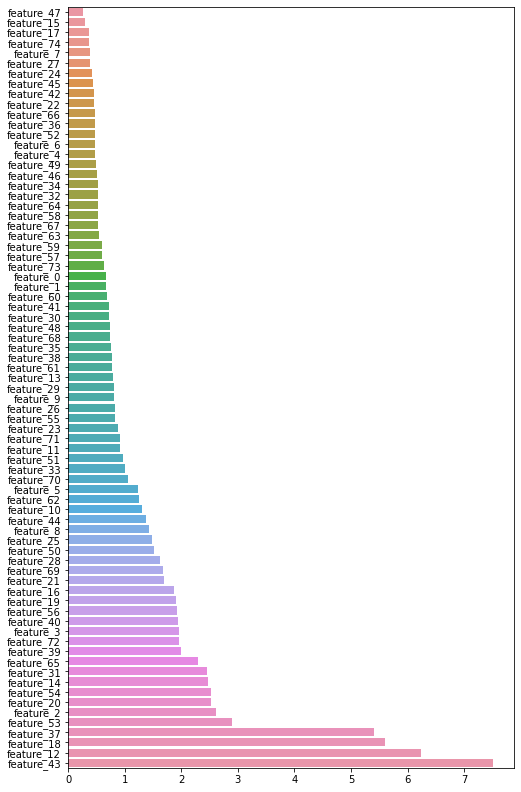

In [ ]:
fi = pd.Series(model.feature_importances_, index=x_train.columns).sort_values()
fig = plt.figure(figsize=(8,14))
sns.barplot(y=fi.index, x=fi)

In [ ]:
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train, y_train, test_size=0.2, shuffle=True)
model.select_features(
                X_train,
                Y_train,
                eval_set=(X_valid, Y_valid),
                features_for_select=list(range(X_train.shape[1])),
                num_features_to_select=100,
                algorithm='RecursiveByShapValues',
                steps=None,
                shap_calc_type=None,
                train_final_model=False,
                verbose=None,
                logging_level='Silent',
                plot=True)

In [ ]:
from catboost.utils import get_gpu_device_count
get_gpu_device_count()

In [ ]:
def objective(trial,data=x_train,target=y_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {'n_estimators':trial.suggest_int("n_estimators", 2000, 25000),
              'tree_method':'gpu_hist',
              'eval_metric':'mlogloss',
              'gamma':trial.suggest_uniform('gamma', .2, .5),
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.5),
              'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
              'reg_alpha':trial.suggest_int('reg_alpha', 1, 5),
              'subsample': trial.suggest_uniform('subsample',0,1),
              'max_depth': trial.suggest_int('max_depth',1,15),
              'objective':'multi:softprob',
              'min_child_weight':trial.suggest_int('min_child_weight', 100, 200),
              'colsample_bytree':trial.suggest_uniform('colsample_bytree',0.2, .4),
              'colsample_bynode':trial.suggest_uniform('colsample_bynode', .2, .4),
              'colsample_bylevel':trial.suggest_uniform('colsample_bylevel', .65, .75)
               }
    model = xgboost.XGBClassifier(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict_proba(X_test)


    log_loss_multi = log_loss(y_test, y_preds)
    
    return log_loss_multi

In [ ]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-06-29 07:39:16,344] A new study created in memory with name: no-name-fc6fbea9-f366-401f-80a7-938afb9d2a59
[I 2021-06-29 07:39:36,453] Trial 0 finished with value: 1.760611058209464 and parameters: {'n_estimators': 18866, 'gamma': 0.4088428675417628, 'learning_rate': 0.2620641631188869, 'reg_lambda': 13.152304737915578, 'reg_alpha': 5, 'subsample': 0.01718091564643065, 'max_depth': 4, 'min_child_weight': 165, 'colsample_bytree': 0.28121399286709836, 'colsample_bynode': 0.3557914022387126, 'colsample_bylevel': 0.6882922439605854}. Best is trial 0 with value: 1.760611058209464.
[I 2021-06-29 07:39:46,857] Trial 1 finished with value: 1.753419739504531 and parameters: {'n_estimators': 9263, 'gamma': 0.4890665882930721, 'learning_rate': 0.40318858365444127, 'reg_lambda': 24.736251783363876, 'reg_alpha': 1, 'subsample': 0.953798564005461, 'max_depth': 13, 'min_child_weight': 115, 'colsample_bytree': 0.21353509204208104, 'colsample_bynode': 0.3170123663207481, 'colsample_bylevel': 0.7

Number of finished trials: 100
Best trial: score 1.7447349471766502, params {'n_estimators': 17740, 'gamma': 0.35851511557818727, 'learning_rate': 0.010013177462139486, 'reg_lambda': 87.07249926122657, 'reg_alpha': 1, 'subsample': 0.9166034290444538, 'max_depth': 13, 'min_child_weight': 131, 'colsample_bytree': 0.26709602373511687, 'colsample_bynode': 0.382577095246454, 'colsample_bylevel': 0.6658609905050997}


In [ ]:
# xgboost ==> 너무 느림
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
preds_xgb = np.zeros((len(x_test), y_train.nunique()))
params_xgb = {
    'n_estimators':study.best_params['n_estimators'],
    'tree_method':'gpu_hist',
    'eval_metric':'mlogloss',
    'gamma':study.best_params['gamma'],
    'learning_rate' : study.best_params['learning_rate'],
    'reg_lambda': study.best_params['reg_lambda'],
    'reg_alpha': study.best_params['reg_alpha'],
    'subsample': study.best_params['subsample'],
    'max_depth': study.best_params['max_depth'],
    'objective':'multi:softprob',
    'min_child_weight':study.best_params['min_child_weight'],
    'colsample_bytree':study.best_params['colsample_bytree'],
    'colsample_bynode':study.best_params['colsample_bynode'],
    'colsample_bylevel':study.best_params['colsample_bylevel']
}

for i, (train_index, valid_index) in enumerate(skf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_xgb = xgboost.XGBClassifier(**params_xgb)
  model_xgb.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_valid, Y_valid)], verbose=100, early_stopping_rounds=70, eval_metric='mlogloss')
  preds_xgb += model_xgb.predict_proba(x_test)/skf.n_splits

[0]	validation_0-mlogloss:2.19267	validation_1-mlogloss:2.19272
[100]	validation_0-mlogloss:1.92085	validation_1-mlogloss:1.92529
[200]	validation_0-mlogloss:1.82050	validation_1-mlogloss:1.82859
[300]	validation_0-mlogloss:1.77667	validation_1-mlogloss:1.78822
[400]	validation_0-mlogloss:1.75488	validation_1-mlogloss:1.76989
[500]	validation_0-mlogloss:1.74246	validation_1-mlogloss:1.76096
[600]	validation_0-mlogloss:1.73426	validation_1-mlogloss:1.75631
[700]	validation_0-mlogloss:1.72813	validation_1-mlogloss:1.75369
[800]	validation_0-mlogloss:1.72307	validation_1-mlogloss:1.75205
[900]	validation_0-mlogloss:1.71865	validation_1-mlogloss:1.75103
[1000]	validation_0-mlogloss:1.71463	validation_1-mlogloss:1.75027
[1100]	validation_0-mlogloss:1.71096	validation_1-mlogloss:1.74976
[1200]	validation_0-mlogloss:1.70752	validation_1-mlogloss:1.74939
[1300]	validation_0-mlogloss:1.70423	validation_1-mlogloss:1.74917
[1400]	validation_0-mlogloss:1.70115	validation_1-mlogloss:1.74898
[1500]	

In [ ]:
submit = pd.read_csv('/kaggle/input/tabular-playground-series-jun-2021/sample_submission.csv')
submit = submit.set_index('id')

In [ ]:
preds = (preds_cat + preds_xgb)/2 # ensemble

In [ ]:
for i in range(9):
    submit.iloc[:,i] = preds_xgb[:,i]

In [ ]:
# xgb 오버피팅

In [ ]:
submit.to_csv('submit21.csv')

# NN 파이토치 필사본

In [ ]:
import os
import sys
import datetime

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import optuna
from optuna.trial import TrialState

In [ ]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=42)

for train_index, val_index in sss.split(x_train, y_train):
    print(f'train size:{len(train_index)}')
    print(f'val size:{len(val_index)}')
    X_train, X_val = x_train.iloc[train_index], x_train.iloc[val_index]
    Y_train, Y_val = y_train.iloc[train_index], y_train.iloc[val_index]

# Optuna

In [ ]:
pip install optuna

In [ ]:
pip install skorch

In [ ]:
import optuna
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
CLASSES = y_train.nunique()
NUM_FEATURES = x_train.shape[1]
DEVICE = torch.device("cpu" if not torch.cuda.is_available() else "cuda")

BATCHSIZE = 1000
EPOCHS = 10
N_TRAIN_EXAMPLES = BATCHSIZE * 14
N_VALID_EXAMPLES = BATCHSIZE * 6

criterion = nn.CrossEntropyLoss()

def define_model(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 1, 10)
    layers = []

    in_features = NUM_FEATURES
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), y_train.nunique(), 1024)
        layers.append(nn.Linear(in_features, out_features, bias=False))
        layers.append(nn.ReLU(inplace=True))
        p = trial.suggest_float("dropout_l{}".format(i), 0.1, 0.5)
        layers.append(nn.Dropout(p))
        layers.append(nn.BatchNorm1d(out_features))

        in_features = out_features
        
    layers.append(nn.Linear(in_features, CLASSES))

    return nn.Sequential(*layers)

def get_data(X_train, y_train, X_val, y_val):
    train = TensorDataset(torch.Tensor(np.array(X_train)), torch.Tensor(np.array(y_train)))
    train_loader = DataLoader(train, batch_size = 1000, shuffle = True, num_workers=4)

    val = TensorDataset(torch.Tensor(np.array(X_val)), torch.Tensor(np.array(y_val)))
    val_loader = DataLoader(val, batch_size = 1000, shuffle = True, num_workers=4)

    return train_loader, val_loader

def objective(trial):
    model = define_model(trial).to(DEVICE)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", 'AdamW', "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 0.001, 0.5)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr, weight_decay)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    train_loader, valid_loader = get_data(X_train, Y_train, X_val, Y_val)
    
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)

            optimizer.zero_grad()
            output = model(data)
            
            loss = criterion(output, target.long())
            loss.backward()
            optimizer.step()
            lr_scheduler.step(epoch + batch_idx / len(train_loader))

        # Validation of the model.
        model.eval()
        val_loss = []
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valid_loader):
                data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
                output = model(data)
                
                loss = criterion(output, target.long())
                val_loss.append(loss.item())
        
        avg_val_loss = np.mean(val_loss)

        trial.report(avg_val_loss, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return avg_val_loss

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

In [ ]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print('Study statistics:')
print(' Number of finished trials:', len(study.trials))
print(' Number of pruned trials:', len(pruned_trials))
print(' Number of complete trials:', len(complete_trials))

print('Best trial:')
trial = study.best_trial

print(' Value:', trial.value)
print(' Params:')
for key, value in trial.params.items():
    print(f'{key}:{value}')

In [ ]:
optuna.visualization.plot_intermediate_values(study).show()

# 최적화된 파라미터를 가지고 모델링

In [ ]:
class classification_model(nn.Module):
    def __init__(self, n_in, n_out, layers, p=None):
        super(classification_model, self).__init__()
        
        all_layers=[]
        self.n_in = n_in
        self.n_out = n_out
        
        for i in range(len(layers)):
            all_layers.append(nn.Linear(self.n_in, layers[i], bias=False))
            all_layers.append(nn.ReLU(inplace=True))
            if p:
                all_layers.append(nn.Dropout(p[i]))
            all_layers.append(nn.BatchNorm1d(layers[i]))
            
            self.n_in = layers[i]
            
        all_layers.append(nn.Linear(layers[-1], self.n_out))
        
        self.layers=nn.Sequential(*all_layers)
        
    def forward(self, x):
        x = self.layers(x)
        return x
    
    net_name='classification_model'

In [ ]:
batch_size = 1000

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)

for train_index, val_index in sss.split(x_train, y_train):    
    print("TRAIN:\t", train_index, "Size:\t", len(train_index))
    print("VAL:\t", val_index, "Size:\t", len(val_index))
    X_train, X_val = x_train.iloc[train_index], x_train.iloc[val_index]
    Y_train, Y_val = y_train.iloc[train_index], y_train.iloc[val_index]

train = TensorDataset(torch.Tensor(np.array(X_train)), torch.Tensor(np.array(Y_train)))
train_loader = DataLoader(train, batch_size = batch_size, shuffle = True)

val = TensorDataset(torch.Tensor(np.array(X_val)), torch.Tensor(np.array(Y_val)))
val_loader = DataLoader(val, batch_size = batch_size, shuffle = True)

phases = ["train", "val"]
loaders = {"train": train_loader, "val": val_loader}

In [ ]:
"""
Best trial:
 Value: 1.7687533100446065
 Params:
n_layers:1
n_units_l0:880
dropout_l0:0.2116281048320166
optimizer:RMSprop
lr:0.0009784821223970022
"""

layers_=[]
dropout_=[]
l_rate=trial.params['lr']

for i in range(trial.params['n_layers']):
    layers_.append(trial.params[f'n_units_l{i}'])
    dropout_.append(trial.params[f'dropout_l{i}'])
    
device = torch.device('cpu' if not torch.cuda.is_available() else 'cuda')

model = classification_model(x_train.shape[1], y_train.nunique(), layers_, p=dropout_)
model.to(device)

criterion = nn.CrossEntropyLoss()
if trial.params['optimizer'] == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=l_rate)
elif trial.params['optimizer'] == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=l_rate)
elif trial.params['optimizer'] == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=l_rate)
    
print(device)
print(model)

In [ ]:
loss_train=[]
loss_valid=[]
best_validation_loss = 1000
best_epoch=1
correct=0
total=0

n_epochs=50

now = datetime.datetime.now()
weights_path = "./output/{:%Y%m%dT%H%M}".format(now)
os.makedirs(weights_path, exist_ok=True)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
break_st = False

for epoch in range(1, n_epochs+1):
    
    for phase in phases:
        if phase == 'train':
            model.train()
        elif phase == 'val':
            model.eval()
        
        for _, data in enumerate(loaders[phase], 0):
            features, y_true = data[0], data[1]
            features = features.to(device, dtype=torch.float)
            y_true = y_true.to(device, dtype=torch.float)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase=='train'):
                y_pred = model(features)
                
                sm = nn.Softmax(dim=1)  # predict_proba
                pred_percentage = sm(y_pred)
                
                if break_st:
                    break
                    
                y_true = y_true.long()
                
                _, preds = torch.max(pred_percentage, 1)
                total += y_true.size(0)
                correct += (preds == y_true).sum().item()
                
                loss = criterion(y_pred, y_true)
                
                if phase == 'val':
                    loss_valid.append(loss.item())
                    
                if phase == 'train':
                    loss_train.append(loss.item())
                    loss.backward()
                    
                    optimizer.step()
                    lr_scheduler.step(epoch / len(train_loader))
        if break_st:
            break
        if phase == 'train':
            mean_train_loss = np.mean(loss_train)
            acc_train = 100*correct/total
            loss_train = []
            correct = 0
        
        if phase == 'val':
            validation_loss = np.mean(loss_valid)
            acc_valid = 100*correct/total
            loss_valid = []
            correct = 0
            total = 0
                
    if break_st:
        break
    if validation_loss < best_validation_loss:
        print('saving weights...')
        best_epoch = epoch
        best_validation_loss = validation_loss
        torch.save(model.state_dict(),
                   os.path.join(weights_path, 'model.pt'),)
            
    print(f'Epoch={epoch}/{n_epochs}\tloss={mean_train_loss:.4f}\tval_loss={validation_loss:.4f}\tacc={acc_train:.4f}\tval_acc={acc_valid:.4f}')
                


In [ ]:
test = TensorDataset(torch.Tensor(np.array(x_test)))
test_loader = DataLoader(test, batch_size=100000, shuffle=False)

In [ ]:
if not weights_path:
    print('Choose weights path')
    sys.exit()

device = torch.device('cpu' if not torch.cuda.is_available() else 'cuda')

model_name = weights_path + '/model.pt'
print(model_name)
state_dict = torch.load(model_name, map_location=device)
model.load_state_dict(state_dict)
model.eval()

for _, data in enumerate(test_loader, 0):
    features = data[0]
    print(features.size())
    features = features.to(device, dtype=torch.float)
    
    with torch.set_grad_enabled(False):
        y_pred = model(features)
        
        sm = nn.Softmax(dim=1)
        pred_percentage = sm(y_pred)
        
        print(pred_percentage.size())

print(pred_percentage.detach().cpu().numpy())
print('Done!')

In [ ]:
submit = pd.read_csv('../input/tabular-playground-series-jun-2021/sample_submission.csv')
pred_array = pred_percentage.detach().cpu().numpy()
submit.loc[:, 'Class_1':'Class_9'] = pred_array
submit = submit.set_index('id')
submit.head()

In [ ]:
submit.to_csv('./output/submission10.csv')

# NN모델을 써야 점수가 올라간다. 
# Pytorch NN모델을 생성하고 제출하자
# feature_select할게 더 있나? 체크